In [1]:
# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

# Preparation of training and validation datasets

The data was taken from <a href="https://www.kaggle.com/c/digit-recognizer/data">kaggle competition</a>

In [2]:
data = np.genfromtxt('mnist/train.csv', delimiter=',', skip_header=1)
data.shape

(42000, 785)

In [3]:
train_size = 32000

In [4]:
x_train = data[:train_size, 1:]
x_train.shape

(32000, 784)

In [5]:
y_train = data[:train_size, :1]
y_train.shape

(32000, 1)

In [6]:
x_validation = data[train_size:, 1:]
x_validation.shape

(10000, 784)

In [7]:
y_validation = data[train_size:, :1]
y_validation.shape

(10000, 1)

array([3.])

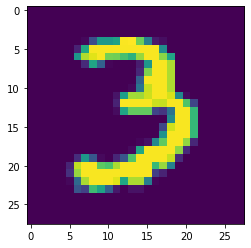

In [8]:
# Image size 28x28
plt.imshow(np.array([x_train[9][i-28:i] for i in range(28,785, 28)]));
y_train[9]

# Activation function

In [9]:
# Hyperbolic tangent
def tanh(x):
    return (math.e**x - math.e**-x) / (math.e**x + math.e**-x)

# Derivative of hyperbolic tangent
def d_tanh(x):
    return 1 - tanh(x)**2

# Softmax in output layer
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps, axis=1)[:, np.newaxis]

# Network architecture

In [10]:
class DigitRecognizer:
    def __init__(self, n_hidden_neurons):
        self.n_hidden_neurons = n_hidden_neurons
        
        self.layer1 = np.random.random((n_hidden_neurons, 784)) - 0.5
        self.b1 = np.random.random((1, n_hidden_neurons)) - 0.5
        
        self.act1 = tanh
        self.d_act1 = d_tanh
        
        self.layer2 = np.random.random((10, n_hidden_neurons)) - 0.5
        self.b2 = np.random.random((1, 10)) - 0.5
    
    def forward(self, x):
        x = x / 255
        # (n_examples, n_hidden_neurons) = (n_examples, 784) @ (n_hidden_neurons, 784).T
        x = x @ self.layer1.T
        # (n_examples, n_hidden_neurons) += (1, n_hidden_neurons)
        x += self.b1
        self.sum1 = x
        # (n_examples, n_hidden_neurons)
        x = self.act1(x)
        # (n_examples, 10) = (n_examples, n_hidden_neurons) @ (10, n_hidden_neurons).T
        x = x @ self.layer2.T
        # (n_examples, 10) += (1, 10)
        x += self.b2
        self.sum2 = x
        # (n_examples, 10)
        return softmax(x)
    
n_neurons = 100 # You can change number of neurnons
net = DigitRecognizer(n_neurons) 

In [11]:
def accuracy(x, y):
    return np.sum(net.forward(x).argmax(axis=1)[:,np.newaxis] == y) / len(y)
accuracy(x_validation, y_validation)

0.1

# Cross entropy loss

In [12]:
def cross_entropy(y_pred, y):
    m = y.shape[0]
    log_likelihood = -np.log(y_pred[range(m),y.reshape(m).astype(int)])
    loss = np.sum(log_likelihood) / m
    return loss

# derivative of cross entropy with softmax
def d_ce(y_pred, y):
    ans = np.copy(y_pred)
    ans[range(len(y)), y.reshape(len(y)).astype(int)] = -1 + y_pred[range(len(y)), y.reshape(len(y)).astype(int)]
    return ans

In [13]:
cross_entropy(net.forward(x_validation), y_validation)

4.096144850461014

# Learning process (back propagation algorithm)

In [14]:
n_epoch = 50
batch_size = 500
lr = 0.001

ce_hist = np.zeros(n_epoch) # history of accuracy changes
ac_hist = np.zeros(n_epoch) # history of cross-entropy changes

In [15]:
def train(net, x, y, lr):
    # (n_examples, 10)
    y_pred = net.forward(x)
    
    # (n_examples, 10)
    error_2 = d_ce(y_pred, y)
    # (1, 10) -= () * (1, 10)
    net.b2 -= lr * np.sum(error_2, axis=0)[np.newaxis,]
    # (10, n_neurons)-=()*(n_examples, 10).T @ (n_examples, n_neurons)
    net.layer2 -= lr * error_2.T @ net.act1(net.sum1)
    
    # (n_examples, n_neurons) = (n_examples, 10) @ (10, n_neurons) * (n_examples, n_neurons)
    error_1 = error_2 @ net.layer2 * net.d_act1(net.sum1)
    # (1, n_neurons)-=()*(1, n_neurons)
    net.b1 -= lr * np.sum(error_1 ,axis=0)[np.newaxis,]
    # (n_neurons, 784) -= lr * (n_examples, n_neurons).T @ (n_examples, 784)
    net.layer1 -= lr * error_1.T @ (x / 255)

In [16]:
for i in range(n_epoch):
    for j in range(batch_size, train_size + 1, batch_size):
        train(net, x_train[j - batch_size: j], y_train[j - batch_size: j], lr)
    
    ce_hist[i] = cross_entropy(net.forward(x_validation), y_validation)
    ac_hist[i] = accuracy(x_validation, y_validation)
    
    sys.stdout.write("\r" + 'Epoch: '+str(i + 1)+' Accuracy: '+str(ac_hist[i])+' CE: '+str(ce_hist[i])+'    ')
    sys.stdout.flush()

Epoch: 50 Accuracy: 0.9539 CE: 0.1513339001530272     

## Results

### Cross-entropy

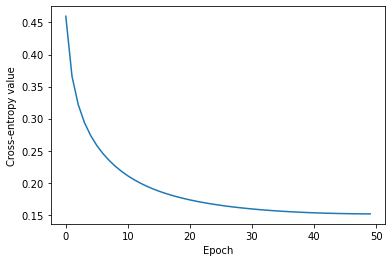

In [17]:
plt.plot(ce_hist)
plt.ylabel('Cross-entropy value')
plt.xlabel('Epoch');

### Accuracy

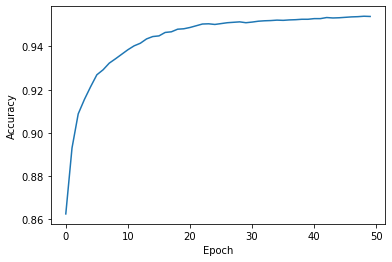

In [18]:
plt.plot(ac_hist)
plt.ylabel('Accuracy')
plt.xlabel('Epoch');

## Test it

### N-th image from mnist

9  - answer
9  - network output


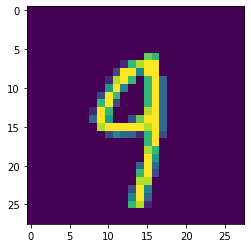

In [19]:
n = 71
plt.imshow(np.array([x_train[n][i-28:i] for i in range(28,785, 28)]));
print(int(y_train[n][0]), " - answer")
print(net.forward(x_train[n][np.newaxis,]).argmax(), " - network output")

### Your image

In [20]:
import matplotlib.image as mpimg

2

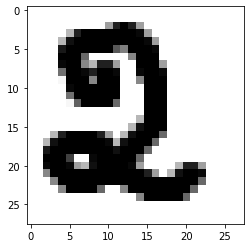

In [21]:
image = mpimg.imread('mnist/2.png')
vector_img = np.array(1 - image[:,:, 0]) * 255
plt.imshow(image);
net.forward(vector_img.reshape(784)[np.newaxis,]).argmax()